In [31]:
import os
import time
import cv2
import scanpy as sc
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import timm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import openslide, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import (
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, silhouette_score,
    davies_bouldin_score, calinski_harabasz_score
)
from sklearn.neighbors import KNeighborsClassifier

In [32]:
training = "v2"  # NoReg_optimized or v2
epoch = "best" # best or number

root = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics"
xenium_sample = "Xenium_Prime_Human_Lung_Cancer_FFPE_outs"      # only lung listed
model_dir = "/rsrch5/home/plm/phacosta/models/public/UNI2-h"

if training == "v2":
    ckpt_dir = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/models/fine_tuned/UNI2/bleep_style_{training}"
else:
    ckpt_dir = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/models/fine_tuned/UNI2/lung_bleep_{training}"

if epoch == "best":
    BEST_CKPT = f"{ckpt_dir}/best.pth"
else: 
    BEST_CKPT = f"{ckpt_dir}/epoch_{epoch}.pth"

ADATA_PATH = f"{root}/{xenium_sample}/preprocessed/fine_tune_refined_v2/processed_xenium_data_fine_tune_refined_v2_annotated.h5ad"
EMB_PATH = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_sample}/scGPT/scGPT_CP.h5ad"
SLIDE_PATH = f"{root}/{xenium_sample}/{xenium_sample.rsplit('_',1)[0]}_he_image_registered.ome.tif"


In [33]:
# ─── UNI2 config exactly as in training ────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

uni2_cfg = dict(  # copied from your training script
    model_name="vit_giant_patch14_224", img_size=224, patch_size=14,
    depth=24, num_heads=24, init_values=1e-5, embed_dim=1536,
    mlp_ratio=2.66667*2, num_classes=0, no_embed_class=True,
    mlp_layer=timm.layers.SwiGLUPacked, act_layer=nn.SiLU,
    reg_tokens=8, dynamic_img_size=True)

uni2 = timm.create_model(pretrained=False, **uni2_cfg)

# ─── ProjectionHead and BLEEP_UNI2 definitions (your originals) ───────────────
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim=256, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc   = nn.Linear(projection_dim, projection_dim)
        self.do   = nn.Dropout(dropout)
        self.ln   = nn.LayerNorm(projection_dim)
    def forward(self, x):
        h = self.proj(x)
        x = self.gelu(h)
        x = self.fc(x)
        x = self.do(x)
        return self.ln(x + h)

# level = 0
# level_idx_map = {
#     0: [119,120,135,136],                                # 2×2
#     1: [102,103,104,105,118,119,120,121,                 # 4×4
#         134,135,136,137,150,151,152,153],
# }
# center_idx = torch.tensor(level_idx_map[level])

# prefix_tokens = getattr(uni2, "num_prefix_tokens")  # fallback reg_tokens + cls 
# level_idx_map = {
#     0: torch.tensor([119,120,135,136]),
#     1: torch.tensor([102,103,104,105,118,119,120,121,134,135,136,137,150,151,152,153])}

# idx_center = level_idx_map[level].to(device)

# ──────────────────────────────────────────────────────────────────────────────
#  BLEEP-UNI2  (evaluation / inference variant)
# ──────────────────────────────────────────────────────────────────────────────
class BLEEP_UNI2(nn.Module):
    """
    Evaluation-time wrapper for a fine-tuned UNI2 + BLEEP projection heads.
    Exposes two helpers:
        encode_image(imgs)  -> (B, 256)
        encode_gene(genes)  -> (B, 256)
    """
    def __init__(
        self,
        img_enc: nn.Module,
        gene_dim: int,
        morph_dim: int = 1536,           # UNI2 embed dim
        init_tau: float = 0.07,          # just to reconstruct logit_scale
        center_idx: torch.Tensor = torch.tensor([119, 120, 135, 136]),
        prefix_tokens: int = 9           # CLS (1) + REG (8)
    ):
        super().__init__()

        # backbones & heads
        self.image_encoder = img_enc
        self.image_proj    = ProjectionHead(morph_dim)
        self.gene_proj     = ProjectionHead(gene_dim)

        # ----- learnable temperature (present in checkpoint) -----
        # frozen during inference but included so `load_state_dict`
        # finds an identical key shape.
        self.logit_scale = nn.Parameter(
            torch.log(torch.tensor(1.0 / init_tau)),
            requires_grad=False
        )

        # ----- token selection helpers -----
        self.prefix_tokens = prefix_tokens
        self.register_buffer(                # moves with .to(device)
            "center_idx",
            center_idx.long(),
            persistent=False
        )

    # ------------------------------------------------------------------
    #  helpers
    # ------------------------------------------------------------------
    @torch.no_grad()
    def encode_image(self, imgs: torch.Tensor) -> torch.Tensor:
        """
        imgs : (B,3,224,224)  – pre-processed image patches
        returns (B, 256)      – L2-normalised image embeddings
        """
        tok     = self.image_encoder.forward_features(imgs)        # (B, 265,1536)
        spatial = tok[:, self.prefix_tokens:, :]                   # drop CLS+REG
        center  = spatial.index_select(1, self.center_idx).mean(1) # (B,1536)
        return F.normalize(self.image_proj(center), dim=-1)

    @torch.no_grad()
    def encode_gene(self, genes: torch.Tensor) -> torch.Tensor:
        """
        genes : (B, gene_dim) – scGPT (or similar) gene embeddings
        returns (B, 256)      – L2-normalised gene embeddings
        """
        return F.normalize(self.gene_proj(genes), dim=-1)


In [34]:
# ─── Prepare data (Anndata + slide)  ──────────────────────────────────────────
print("Loading cell data")
adata = sc.read_h5ad(ADATA_PATH)
cells = adata.obs
print("Loading gene embedding")
gdata   = sc.read_h5ad(EMB_PATH)
genes_df = pd.DataFrame(gdata.obsm["X_scGPT"], index=cells.index)
print("Cells:", cells.shape[0], "| Gene‑embedding dim:", genes_df.shape[1])

print("Loading slide")
slide = openslide.open_slide(SLIDE_PATH)
mpp = float(slide.properties["openslide.comment"].split('PhysicalSizeX=\"')[1].split('\"')[0])
scale = 0.5 / mpp
tfm = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])

class CellDS(Dataset):
    def __init__(self, slide, df, gdf, tfm, scale, ps=224):
        self.slide, self.df, self.gdf, self.tfm, self.scale, self.ps = slide, df.reset_index(drop=False), gdf, tfm, scale, ps
    def __len__(self): 
        return len(self.df)
    def _patch(self,x,y):
        big=int(self.ps*self.scale); tlx,tly=int(x-big/2),int(y-big/2)
        return self.slide.read_region((tlx,tly),0,(big,big)).convert("RGB").resize(
            (self.ps,self.ps), Image.Resampling.LANCZOS)
    def __getitem__(self,i):
        row=self.df.iloc[i]
        img=self.tfm(self._patch(row.x_centroid,row.y_centroid))
        gene=torch.tensor(self.gdf.loc[row['index']].values, dtype=torch.float32)
        return {"image":img, "gene":gene, "cid":row['index']}

loader = DataLoader(CellDS(slide,cells,genes_df,tfm,scale),
                    batch_size=256,num_workers=8,pin_memory=True)

Loading cell data
Loading gene embedding
Cells: 244659 | Gene‑embedding dim: 512
Loading slide


In [35]:
# ─── Load checkpoint weights into freshly built model ─────────────────────────

print("Loading checkpoint:", BEST_CKPT)
ckpt  = torch.load(BEST_CKPT, map_location=device)
gene_dim = genes_df.shape[1]

model = BLEEP_UNI2(uni2, gene_dim).to(device)
model.load_state_dict(ckpt["model"], strict=True)
model.to(device).eval()

Loading checkpoint: /rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/models/fine_tuned/UNI2/bleep_style_v2/best.pth


BLEEP_UNI2(
  (image_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): GluMlp(
          (fc1): Linear(in_features=1536, out_features=8192, bias=True)
          (act): SiLU()

In [36]:
# ─── Extract embeddings ───────────────────────────────────────────────────────
m_z, g_z, cids = [], [], []
with torch.no_grad():
    for b in tqdm(loader, desc="Embedding"):
        m_z.append(model.encode_image(b["image"].to(device,non_blocking=True)).cpu())
        g_z.append(model.encode_gene (b["gene" ].to(device,non_blocking=True)).cpu())
        cids.extend(b["cid"])
m_z, g_z = torch.cat(m_z), torch.cat(g_z)
joint = 0.5*(m_z+g_z)

Embedding: 100%|██████████| 956/956 [33:18<00:00,  2.09s/it]


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 256 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
2025-06-26 01:19:45.910831: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 01:19:45.925282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-26 01:19:45.943411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-26 01:

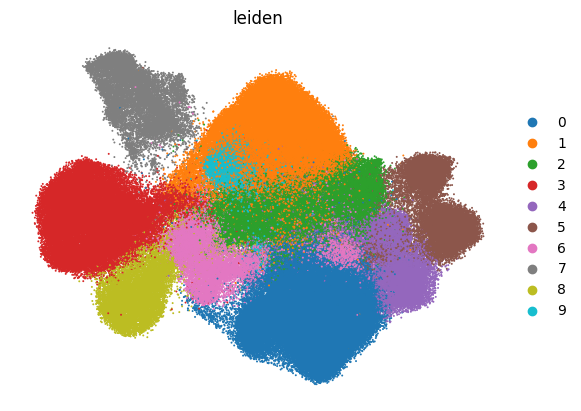

In [37]:
# ─── UMAP + Leiden + metrics (same as before) ────────────────────────────────
adata_e = sc.AnnData(m_z.numpy(), obs=pd.DataFrame(index=cids))
sc.pp.neighbors(adata_e, n_neighbors=15)
sc.tl.umap(adata_e); sc.tl.leiden(adata_e, resolution=0.5)
sc.pl.umap(adata_e, color="leiden", size=8, legend_loc="right margin", frameon=False)

adata_e.obs["x"] = cells.loc[adata_e.obs_names,"x_centroid"]
adata_e.obs["y"] = cells.loc[adata_e.obs_names,"y_centroid"]
colmap = {str(i):c for i,c in enumerate(adata_e.uns["leiden_colors"])}

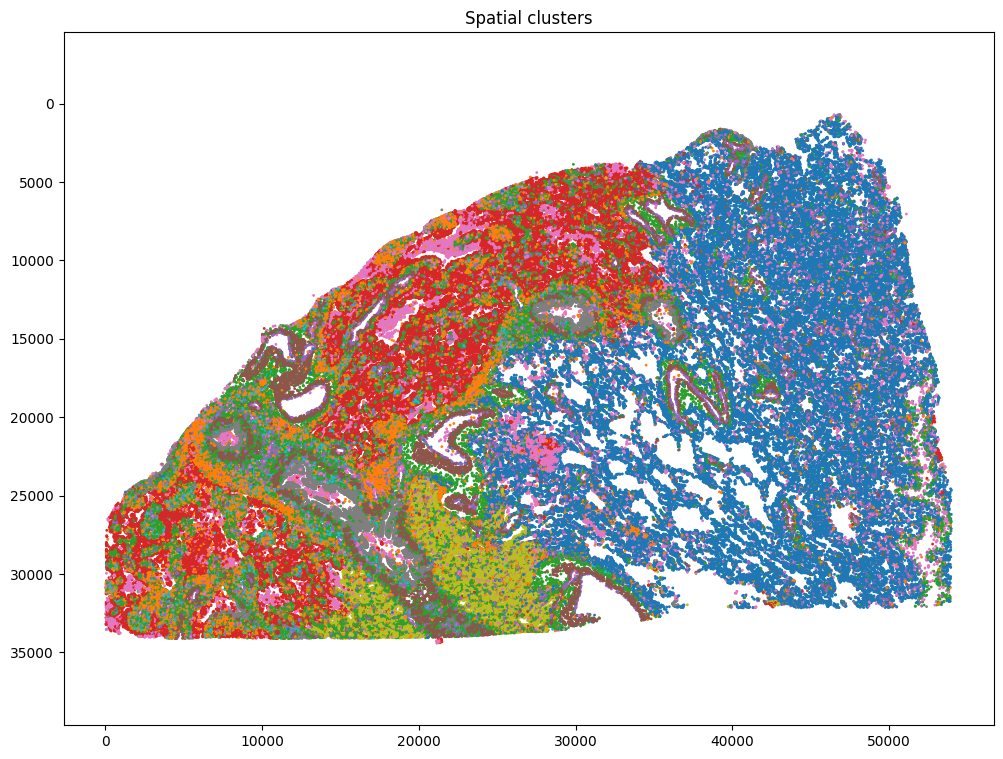


=== Metrics ===
ARI            :  0.221
NMI            :  0.350
Homogeneity    :  0.317
Completeness   :  0.391
Purity         :  0.542
Silhouette     :  0.031
DaviesBouldin  :  4.116
CalinskiHarabasz:  3739.034
kNN            :  0.682


In [38]:
plt.figure(figsize=(12,9))
plt.scatter(adata_e.obs["x"], adata_e.obs["y"],
            c=adata_e.obs["leiden"].astype(str).map(colmap), s=1)
plt.gca().invert_yaxis(); plt.axis("equal"); plt.title("Spatial clusters"); plt.show()

clust = adata_e.obs["leiden"].astype(int).values
true  = adata.obs.loc[adata_e.obs_names, "singleR_class"].values
ext   = dict(ARI=adjusted_rand_score(true,clust),
             NMI=normalized_mutual_info_score(true,clust),
             Homogeneity=homogeneity_score(true,clust),
             Completeness=completeness_score(true,clust))
ext["Purity"] = pd.crosstab(true,clust).max(1).sum()/len(clust)

X = m_z.numpy()
intm = dict(Silhouette=silhouette_score(X,clust,sample_size=min(20000,len(clust))),
            DaviesBouldin=davies_bouldin_score(X,clust),
            CalinskiHarabasz=calinski_harabasz_score(X,clust))
knn = KNeighborsClassifier(5).fit(X,true)
print("\n=== Metrics ===")
for k,v in {**ext,**intm,"kNN":knn.score(X,true)}.items():
    print(f"{k:15s}: {v: .3f}")

In [10]:
# embedding_dir = f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/embeddings/public_data/{xenium_sample}"

# # Assuming 'cids' is a list of IDs for each embedding
# assert len(cids) == len(m_z) == len(g_z), "Length mismatch between IDs and embeddings"

# # Convert to numpy arrays
# morph_emb_final = m_z.numpy()
# gene_emb_final = g_z.numpy()
# joint_embeddings = joint.numpy()

# # Create DataFrames with cids as index
# gene_emb_df  = pd.DataFrame(gene_emb_final, index=cids)
# morph_emb_df = pd.DataFrame(morph_emb_final, index=cids)
# joint_emb_df = pd.DataFrame(joint_embeddings, index=cids)

# # Save to CSV
# gene_emb_df.to_csv(os.path.join(embedding_dir, "contrastive_learning", f"gene_projection_embeddings_bleep_{training}.csv"))
# morph_emb_df.to_csv(os.path.join(embedding_dir, "contrastive_learning", f"morph_projection_embeddings_bleep_{training}.csv"))
# joint_emb_df.to_csv(os.path.join(embedding_dir, "contrastive_learning", f"joint_embeddings_bleep_{training}.csv"))


OrderedDict([('logit_scale', tensor(0.1202, device='cuda:0')),
             ('image_encoder.cls_token',
              tensor([[[ 1.7239e-02,  2.9690e-02, -2.2802e-01,  ..., -4.9170e-02,
                         7.3665e-04, -1.0730e-04]]], device='cuda:0')),
             ('image_encoder.reg_token',
              tensor([[[ 0.0088, -0.0006,  0.0231,  ..., -0.0408, -0.0015, -0.0314],
                       [ 0.0211, -0.0047,  0.0678,  ..., -0.0052,  0.0245,  0.0141],
                       [-0.0048,  0.0177,  0.0854,  ..., -0.0355,  0.0024, -0.0199],
                       ...,
                       [ 0.0125,  0.0052,  0.0342,  ..., -0.0190,  0.0452, -0.0212],
                       [ 0.0181,  0.0079, -0.0522,  ..., -0.0324,  0.0026, -0.0016],
                       [ 0.0110,  0.0143, -0.0283,  ..., -0.0394,  0.0137, -0.0314]]],
                     device='cuda:0')),
             ('image_encoder.pos_embed',
              tensor([[[ 5.6555e-03,  1.0831e-03,  1.3747e-03,  ...,  2.0719e-02